# Import

In [65]:
# import yfinance as yf
import pandas as pd
import os
from os.path import join
from datetime import datetime, timezone, timedelta
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import logging
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from yforseer.networks import StockNet
from yforseer.datasets import StockDataset
from yforseer.trainers import StockNetTrainer
import mlflow
from tqdm import tqdm



# Dataset and loader

In [66]:

# Load dataset
load_array_pth = 'data/yahoo/artifacts/data_array.npz'
data = torch.from_numpy(np.load(load_array_pth)['data']).to(torch.float32)
num_days = data.shape[1]
test_size = int(0.1 * num_days)
train_size = num_days - test_size
train_data = data[:, :train_size]
test_data = data[:, train_size:]
train_dataset = StockDataset(data = train_data, memory=60, lookahead=30, mode='last')
test_dataset = StockDataset(data = test_data, memory=60, lookahead=30, mode='last')
print('train_dataset:', len(train_dataset))
print('test_dataset:', len(test_dataset))


train_dataset: 5283
test_dataset: 507


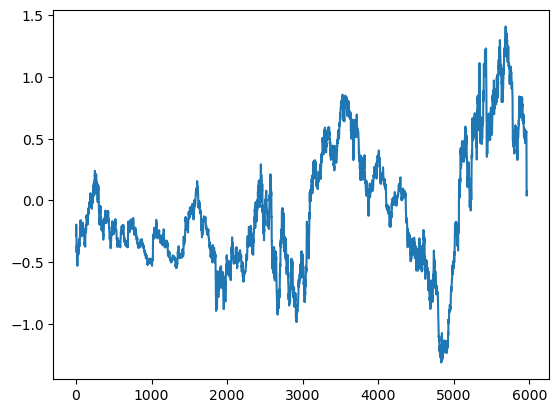

In [68]:
data2 = (data - data.mean(dim=0, keepdim=True)) / data.std(dim=0, keepdim=True)
plt.plot(data2[0, :])

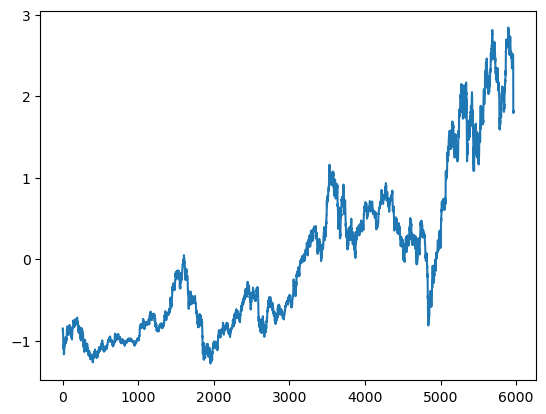

In [69]:
plt.plot(data[0, :])

# Evaluation

In [21]:
import numpy as np
from sklearn.metrics import f1_score

In [29]:
 xlast = np.array(
    [5, 10, 20, 200, 350, 100]
 )

 ypred = np.array(
    [20, 2, 24, 180, 450, 50]
 )

 ytest = np.array(
    [10, 7, 18, 210, 500, 10]

 )

# over prediction up
# over prediction down
# wrong trend: up instead of down
# wrong trend: down instead of up
# under prediction up
# under prediction down
 

In [62]:
xlast_batch = np.repeat(xlast.reshape(1, -1) , axis=0, repeats=2)
ypred_batch = np.repeat(ypred.reshape(1, -1) , axis=0, repeats=2)
ytest_batch = np.repeat(ytest.reshape(1, -1) , axis=0, repeats=2)


def evaluate_stock_trend_prediction(xlast, ypred, ytest, batch=True):

    change_pred = (ypred - xlast) / xlast
    change_test = (ytest - xlast) / xlast

    # trend accuracy
    trend_pred = np.sign(change_pred)
    trend_test = np.sign(change_test)
    if batch:
        trend_accuracy = np.mean(trend_pred == trend_test, axis=1).squeeze()
    else:
        trend_accuracy = np.mean(trend_pred == trend_test)


    # Buy return rate
    change_pred_rise = change_pred.copy()
    change_test_rise = change_test.copy()
    fall_mask = change_pred < 0
    change_pred_rise[fall_mask] = 0
    change_test_rise[fall_mask] = 0
    if batch:
        buy_weights = change_pred_rise / change_pred_rise.sum(axis=1, keepdims=True)
        buy_return = (change_test_rise * buy_weights).sum(axis=1, keepdims=True).squeeze()
    else:
        buy_weights = change_pred_rise / change_pred_rise.sum()
        buy_return = (change_test_rise * buy_weights).sum()

    # Sell return rate
    change_pred_fall = change_pred.copy()
    change_test_fall = change_test.copy()
    rise_mask = change_pred > 0
    change_pred_fall[rise_mask] = 0
    change_test_fall[rise_mask] = 0
    if batch:
        sell_weights = np.abs(change_pred_fall) / np.abs(change_pred_fall).sum(axis=1, keepdims=True)
        sell_return = (-change_test_fall * sell_weights).sum(axis=1, keepdims=True).squeeze()
    else:
        sell_weights = np.abs(change_pred_fall) / np.abs(change_pred_fall).sum()
        sell_return = (-change_test_fall * sell_weights).sum()

    return trend_accuracy, buy_return, sell_return


a, b, c = evaluate_stock_trend_prediction(xlast, ypred, ytest, batch=False)
d, e, f = evaluate_stock_trend_prediction(xlast_batch, ypred_batch, ytest_batch, batch=True)


In [64]:
print(a, b, c)

print(d, e, f)

0.6666666666666666 0.8900468384074941 0.4892857142857143
[0.66666667 0.66666667] [0.89004684 0.89004684] [0.48928571 0.48928571]


In [52]:
0.6666666666666666 0.8900468384074941 0.4892857142857143
[0.66666667 0.66666667] [0.89004684 0.89004684] [0.48928571 0.48928571]


array([[ 3.        , -0.8       ,  0.2       , -0.1       ,  0.28571429,
        -0.5       ],
       [ 3.        , -0.8       ,  0.2       , -0.1       ,  0.28571429,
        -0.5       ]])

In [59]:
change_pred = (ypred - xlast) / xlast
change_test = (ytest - xlast) / xlast

print('change_pred:', change_pred)
print('change_test:', change_test)

# trend accuracy and f1
trend_pred = np.sign(change_pred)
trend_test = np.sign(change_test)
trend_accuracy = np.mean(trend_pred == trend_test)
trend_f1 = f1_score(trend_test, trend_pred)
print('trend_accuracy:', trend_accuracy)
print('trend_f1:', trend_f1)

# Buy return rate
rise_mask = change_pred > 0
buy_weights = change_pred[rise_mask] / change_pred[rise_mask].sum()
buy_return = (change_test[rise_mask] * buy_weights).sum()
print('buy_weights', buy_weights)
print('buy_return', buy_return)

# Sell return rate
fall_mask = change_pred < 0
sell_weights = -change_pred[fall_mask] / -change_pred[fall_mask].sum()
sell_return = (-change_test[fall_mask] * sell_weights).sum()
print('sell_weights', sell_weights)
print('sell_return', sell_return)




change_pred: [ 3.         -0.8         0.2        -0.1         0.28571429 -0.5       ]
change_test: [ 1.         -0.3        -0.1         0.05        0.42857143 -0.9       ]
trend_accuracy: 0.6666666666666666
trend_f1: 0.6666666666666666
buy_weights [0.86065574 0.05737705 0.08196721]
buy_return 0.8900468384074941
sell_weights [0.57142857 0.07142857 0.35714286]
sell_return 0.4892857142857143
